## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [122]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [123]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [124]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [125]:
# Opening JSON file
f = open('/content/gdrive/MyDrive/NLP/Semantic_Case_study/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)
pd.set_option('display.max_colwidth', None)

## Data preparation

In [126]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [128]:
#print the column names
col_list = list(df.columns)

In [129]:
#Assign new column names
#This Utility function is used to rename the column prefixes
def rename_columns(col):
    col = col.removeprefix("_source.")
    col = col.removeprefix("_")
    return col
df.columns = [rename_columns(col) for col in col_list ]

In [130]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']==''] = np.nan

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [132]:
# Find the number of missing values percentage
(df.isnull().mean())*100

index                        73.092590
type                         73.092590
id                           73.092590
score                        73.092590
tags                         95.127246
zip_code                     79.023917
complaint_id                 73.092590
issue                        73.092590
date_received                73.092590
state                        73.275191
consumer_disputed            73.092590
product                      73.092590
company_response             73.092590
company                      73.092590
submitted_via                73.092590
date_sent_to_company         73.092590
company_public_response      99.997446
sub_product                  75.785629
timely                       73.092590
complaint_what_happened      73.092590
sub_issue                    83.532747
consumer_consent_provided    73.092590
dtype: float64

In [133]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])


In [134]:
#Remove all duplicates rows
df=df.drop_duplicates(subset=['complaint_what_happened'])

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20930 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      20930 non-null  object 
 1   type                       20930 non-null  object 
 2   id                         20930 non-null  object 
 3   score                      20930 non-null  float64
 4   tags                       3800 non-null   object 
 5   zip_code                   16324 non-null  object 
 6   complaint_id               20930 non-null  object 
 7   issue                      20930 non-null  object 
 8   date_received              20930 non-null  object 
 9   state                      20789 non-null  object 
 10  consumer_disputed          20930 non-null  object 
 11  product                    20930 non-null  object 
 12  company_response           20930 non-null  object 
 13  company                    20930 non-null  object 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
df.shape

(20930, 22)

In [136]:
# Function to clean the text and remove all the unnecessary elements.
pd.options.mode.chained_assignment = None
df.complaint_what_happened=df.complaint_what_happened.astype(str)
def clean_text(text):
    text = text.lower()                                              # Make text lowercase
    text = re.sub(r'\[.*?\]', '', text)                              # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)                             # Remove words containing numbers
    return text

df_clean = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

In [137]:
#Function to Lemmatize the texts
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [139]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean["Complaint_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [140]:
df_clean.head(5)

,complaint_what_happened,Complaint_lemmatize
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not sta

In [141]:
#Function to extract the POS tags

def pos_tag(text):
  noun_list = []
  doc = nlp(text)
  for tok in doc:
    if (tok.tag_ == "NN" ):
        noun_list.append(tok.text)
  return " ".join(noun_list)

df_clean["complaint_POS_removed"] = df_clean.apply(lambda x: pos_tag(x['complaint_what_happened']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [142]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and with

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [143]:
#lenght of character in 'complaint_POS_removed'
complaint_char_len=[len(x) for x in df_clean['complaint_POS_removed']]
#Print length of first 5 complaints
complaint_char_len[:5]

[146, 105, 59, 371, 163]

Text(0.5, 0, 'Complaint character length')

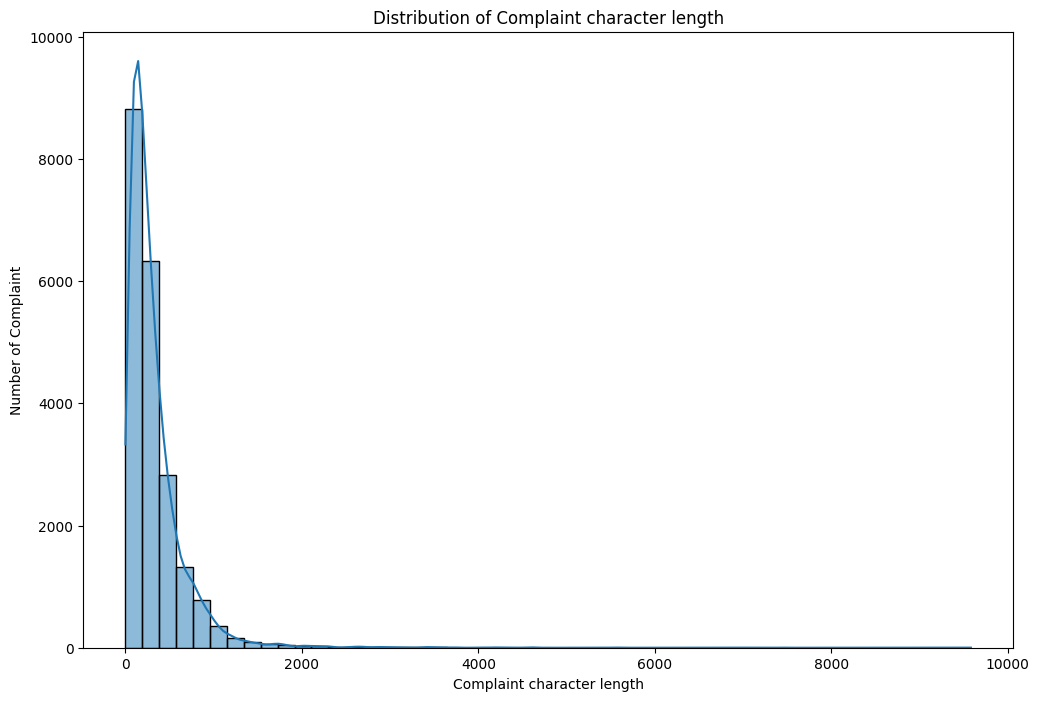

In [144]:
# Function to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[12,8])
sns.histplot(data = complaint_char_len,bins=50,kde=True)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')

#### Find the top 40 words by frequency among all the articles after processing the text.

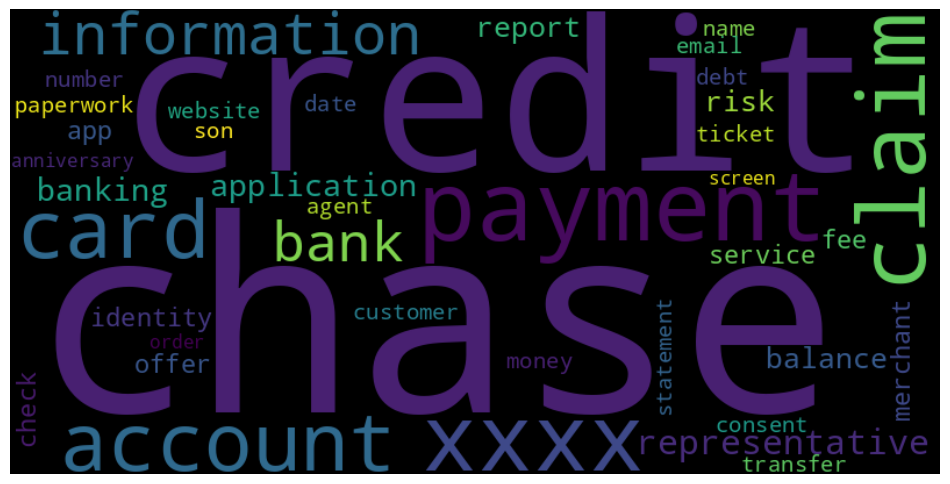

In [145]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#using built-in STOPWORDS
wordcloud = WordCloud(
    width=800,
    height=400,
    max_words=40,
    random_state=42,
    stopwords=set(STOPWORDS)
).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [146]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [147]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,xxxx card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refu

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [148]:
# Common utility to get top n gram
def get_top_ngram_words(text,n_gram,count=30):
  vector = CountVectorizer(ngram_range=(n_gram, n_gram),stop_words='english').fit(text)
  bow = vector.transform(text) # Bag Of Words
  sow = bow.sum(axis=0) #Sum of Words
  # Get the word frequency
  # Iterate thru vector vocabulary (dictionary), and get the word, and its occurance count
  word_freq = [(word, sow[0, idx]) for word, idx in vector.vocabulary_.items()]
  word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
  return word_freq[:count]

In [149]:
#Print the top 10 words in the unigram frequency
top_unigram_words = get_top_ngram_words(df_clean['complaint_POS_removed'].values.astype('U'),1)
df_clean_unigram = pd.DataFrame(top_unigram_words, columns = ['unigram' , 'count'])
df_clean_unigram.head(10)

,unigram,count
0,chase,52534
1,xxxx,43380
2,account,40691
3,credit,31950
4,card,26476
5,bank,19887
6,payment,13922
7,time,11939
8,money,11917
9,xxxxxxxx,10766


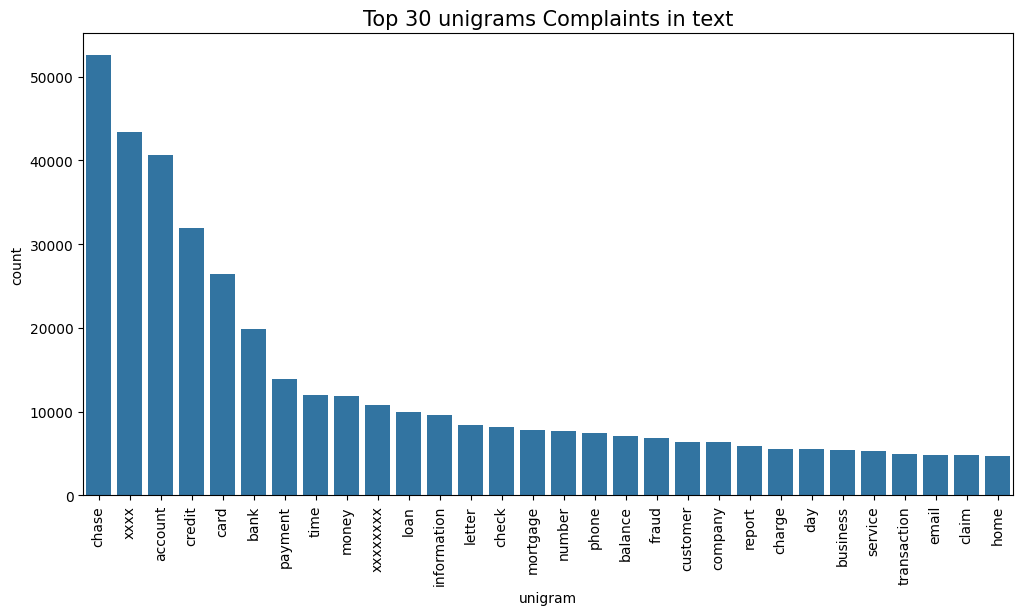

In [150]:
# Plot Top 30 unigram words along with count
plt.figure(figsize=(12,6))
sns.barplot(x='unigram', y='count', data=df_clean_unigram)
plt.xticks(rotation=90)
plt.title("Top 30 unigrams Complaints in text", fontsize=15)
plt.show()

In [151]:
#Print the top 10 words in the bigram frequency
top_bigram_words = get_top_ngram_words(df_clean['complaint_POS_removed'].values.astype('U'),2,10)
top_bigram_words

[('credit card', 11003),
 ('xxxx xxxx', 5269),
 ('chase credit', 3241),
 ('credit report', 3187),
 ('account chase', 3173),
 ('chase account', 3138),
 ('customer service', 3008),
 ('account account', 2915),
 ('bank account', 2442),
 ('chase bank', 2063)]

In [152]:
#Code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_bigram_words = get_top_ngram_words(df_clean['complaint_POS_removed'].values.astype('U'),2)
df_clean_bigram = pd.DataFrame(top_bigram_words, columns = ['bigram' , 'count'])
df_clean_bigram.head(10)

,bigram,count
0,credit card,11003
1,xxxx xxxx,5269
2,chase credit,3241
3,credit report,3187
4,account chase,3173
5,chase account,3138
6,customer service,3008
7,account account,2915
8,bank account,2442
9,chase bank,2063


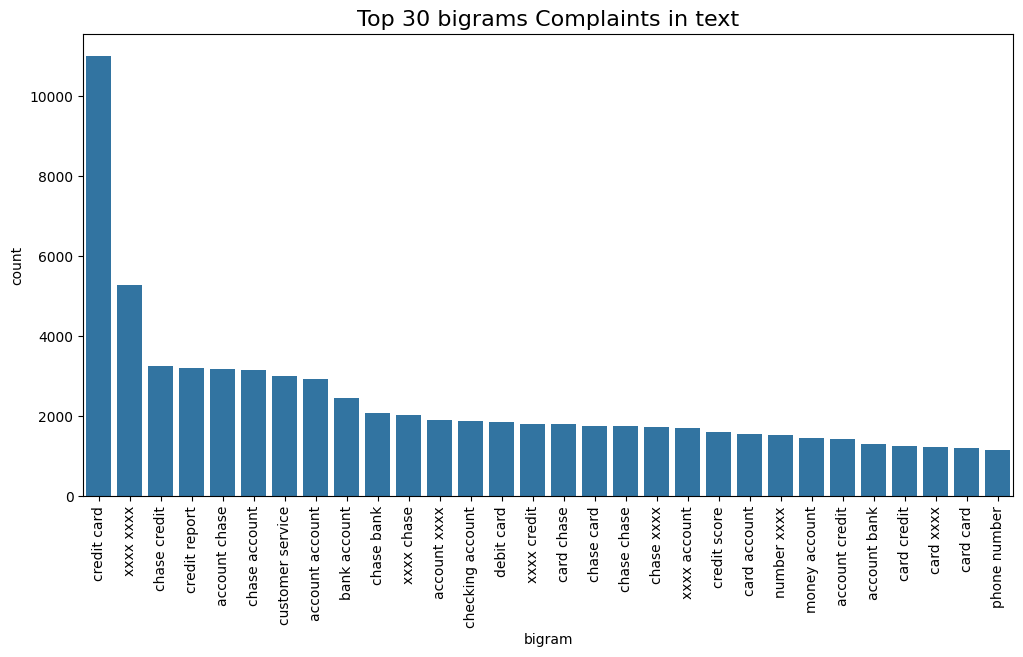

In [153]:
# Plot Top 30 bigram words along with count
plt.figure(figsize=(12,6))
sns.barplot(x='bigram', y='count', data=df_clean_bigram)
plt.xticks(rotation=90)
plt.title("Top 30 bigrams Complaints in text", fontsize=16)
plt.show()

In [154]:
#Code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_trigram_words = get_top_ngram_words(df_clean['complaint_POS_removed'].values.astype('U'),3)
df_clean_trigram = pd.DataFrame(top_trigram_words, columns = ['trigram' , 'count'])
df_clean_trigram.head(10)

,trigram,count
0,chase credit card,1733
1,xxxx xxxx xxxx,1005
2,credit card account,865
3,credit card company,814
4,credit card chase,789
5,xxxx credit card,781
6,credit card credit,635
7,credit card xxxx,502
8,card credit card,462
9,account chase account,405


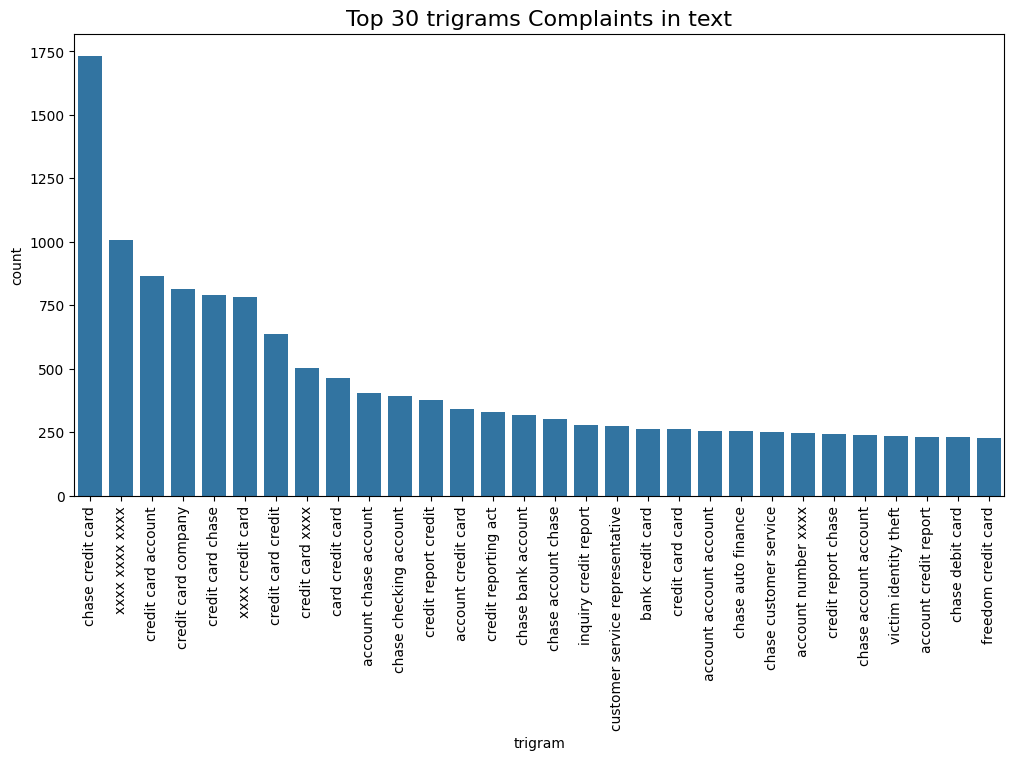

In [155]:
# Plot Top 30 trigram words along with count
plt.figure(figsize=(12,6))
sns.barplot(x='trigram', y='count', data=df_clean_trigram)
plt.xticks(rotation=90)
plt.title("Top 30 trigrams Complaints in text", fontsize=16)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [156]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [157]:
#All masked texts has been removed
df_clean.head(5)

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to cor

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [158]:
#Write your code here to initialise the TfidfVectorizer
vect = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [159]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = vect.fit_transform(df_clean['Complaint_clean'])
pd.DataFrame(doc_term_matrix.toarray(), columns=vect.get_feature_names_out()).head()

,aarp,abandonment,abatement,abbreviation,abide,ability,absence,absurdity,abundance,abuse,...,yment,yoga,youth,yr,yrs,ytd,zilch,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [160]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [181]:
# Function to find optimal number of topics
n_topics = 5 #write the value you want to test out
nmf_model = NMF(n_components=n_topics,random_state =40)
W = nmf_model.fit_transform(doc_term_matrix)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
nmf_model.fit(doc_term_matrix)
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((n_topics, 15)), index=[f'Topic {i + 1}' for i in range(n_topics)],columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(n_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

In [182]:
len(vect.get_feature_names_out())

5744

In [192]:
#Print the Top15 words for each of the topics
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,check,chase,branch,deposit,checking,number,business,fraud,transaction,claim,information,day
Topic 2,card,chase,credit,charge,dispute,fraud,merchant,company,fee,purchase,phone,number,service,time,transaction
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time,rate,sale,information,process,escrow
Topic 4,credit,report,inquiry,score,debt,account,reporting,information,card,limit,identity,company,history,theft,bureaus
Topic 5,payment,balance,month,fee,statement,date,chase,time,auto,day,error,car,history,transfer,account


In [191]:
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

In [193]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.fit_transform(doc_term_matrix)
topic_results.argmax(axis=1)

array([0, 1, 3, ..., 1, 4, 4])

In [200]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)  #write your code to assign topics to each rows.#write your code to assign topics to each rows.

In [201]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has re

In [202]:
#Print the first 5 Complaint for each of the Topics
df_clean_sample=df_clean.groupby('Topic').head(5)
df_clean_sample.sort_values('Topic')

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,account chase auto xxxx,account chase auto,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [203]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [204]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,Account Services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,Others
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [205]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [206]:
df_clean.head()

,complaint_what_happened,Complaint_lemmatize,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has re

In [207]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=  df_clean[['complaint_POS_removed','Topic']]
#training_data=  df_clean[['complaint_POS_removed','Topic']]

In [208]:
training_data.shape

(20930, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [209]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_POS_removed'])


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [251]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,confusion_matrix


# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)


In [252]:
import warnings
warnings.filterwarnings('ignore')

LOGISTIC REGRESSION

In [259]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
lr_predicted = lr.predict(X_test)
print("Confusion Matrix:")
lr_confusion_matrix = confusion_matrix(y_test,lr_predicted)
print(lr_confusion_matrix)
print('\n')
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=lr_predicted))

Confusion Matrix:
[[1127   17    5    4    0]
 [  20 1190    7    6    1]
 [  13   16  703    2    2]
 [  10   19    7  558    1]
 [  19   15   11    4  429]]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1153
           1       0.95      0.97      0.96      1224
           2       0.96      0.96      0.96       736
           3       0.97      0.94      0.95       595
           4       0.99      0.90      0.94       478

    accuracy                           0.96      4186
   macro avg       0.96      0.95      0.96      4186
weighted avg       0.96      0.96      0.96      4186



DECISION TREE

In [260]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_predicted = dt.predict(X_test)

print("Confusion Matrix:")
dt_confusion_matrix = confusion_matrix(y_test,dt_predicted)
print(dt_confusion_matrix)
print('\n')
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=dt_predicted))

Confusion Matrix:
[[1020   65   30   21   17]
 [  86 1023   19   61   35]
 [  28   26  638   23   21]
 [  26   54   16  478   21]
 [  29   31   24   16  378]]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1153
           1       0.85      0.84      0.84      1224
           2       0.88      0.87      0.87       736
           3       0.80      0.80      0.80       595
           4       0.80      0.79      0.80       478

    accuracy                           0.84      4186
   macro avg       0.84      0.84      0.84      4186
weighted avg       0.84      0.84      0.84      4186



Random Forest Classifier

In [261]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
rf_predicted = rfc.predict(X_test)

print("Confusion Matrix:")
rf_confusion_matrix = confusion_matrix(y_test,rf_predicted)
print(rf_confusion_matrix)
print('\n')
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=rf_predicted))

Confusion Matrix:
[[1059   90    3    1    0]
 [ 154 1067    1    2    0]
 [ 148   82  504    2    0]
 [ 102  385    9   99    0]
 [ 202  218   54    3    1]]


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      1153
           1       0.58      0.87      0.70      1224
           2       0.88      0.68      0.77       736
           3       0.93      0.17      0.28       595
           4       1.00      0.00      0.00       478

    accuracy                           0.65      4186
   macro avg       0.80      0.53      0.50      4186
weighted avg       0.75      0.65      0.59      4186



Gaussian Naive Bayes

In [262]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
gb_predicted = nb.predict(X_test.toarray())

print("Confusion Matrix:")
gb_confusion_matrix = confusion_matrix(y_test,gb_predicted)
print(gb_confusion_matrix)
print('\n')
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=gb_predicted))

Confusion Matrix:
[[254  97  71 380 351]
 [214 224  70 443 273]
 [ 52  41 235 179 229]
 [ 46  27  46 402  74]
 [ 54  32  37 176 179]]


Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.22      0.29      1153
           1       0.53      0.18      0.27      1224
           2       0.51      0.32      0.39       736
           3       0.25      0.68      0.37       595
           4       0.16      0.37      0.23       478

    accuracy                           0.31      4186
   macro avg       0.37      0.35      0.31      4186
weighted avg       0.41      0.31      0.31      4186



### Conclusion

- The following 5 topics were identified:
  - Account Services
  - Others
  - Mortgages/ Loans
  - Credit card / Prepaid card
  - Theft/Dispute Reporting

Below 4 Models were run on the data:
- Logistic Regression
- Decision Tree
- Random Forest
- Gaussian Naive Bayes


The observations are as follows:

### Accuracy Score:
  - Logistic Regression (`0.96`) > Decision Tree(`0.84`) > Random Forest (`0.65`) > Gaussian Naive Bayes (`0.31`)



 In summary, as per the above, Logistic Regression is performaing well, as it predicting well  on the customer data. **So Logistic Regression is the recommended model.**

In [ ]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,I want to open a salary account at your downtown branch. Please provide me the procedure.
2,I need to know the number of bank branches and their locations in the city of Dubai


In [248]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [263]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,I want to open a salary account at your downtown branch. Please provide me the procedure.,Account Services
2,I need to know the number of bank branches and their locations in the city of Dubai,Account Services


As per observation on sample data, all the topics of sample compliants are predicted properly.

### Conclusion
As expected 5 topics were indetified namely:

    ->Account Services
    ->Others
    ->Mortgage/Loan
    ->Credit card or prepaid card
    ->Theft/Dispute Reporting

Tried 4 models on the data with accuracies as follows:
| Model | Accuracy |
| ----------- | ----------- |
| Logistic Regression | 0.96 |
| Decision Tree | 0.84 |
| Random Forest | 0.65 |
| Naive Bayes | 0.31 |



#### Accuracy Score:

    ->Logistic Regression (0.96) > Decision Tree(0.84) > Random Forest (0.65) > Gaussian Naive Bayes (0.31)

In summary, as per the above, Logistic Regression is performaing well, as it predicting well on the customer data.
##### So Logistic Regression is the recommended model.